In [12]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

In [72]:
def synthetic_data(w, b, num_examples):  #@save 
    """生成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

true_w = torch.tensor([0.0, -0.0])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [73]:
print('features:', features[0],'\nlabel:', labels[0])

features: tensor([1.6667, 0.3570]) 
label: tensor([4.2052])


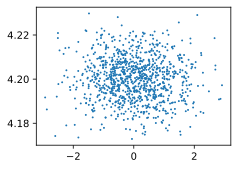

In [74]:
d2l.set_figsize()
d2l.plt.scatter(features[:, 1].detach().numpy(), labels.detach().numpy(), 1);

In [75]:
def data_iter(batch_size, features, labels):   #读取随机样本
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

In [76]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):  #每次读取10个随机样本
    print(X, '\n', y)
    break

tensor([[ 1.5466, -0.1475],
        [ 3.0259,  1.1689],
        [ 0.3468, -0.4041],
        [ 2.2661,  1.1987],
        [ 0.2814, -2.2609],
        [-1.6288, -0.5370],
        [-0.6527,  0.5060],
        [ 0.5618, -0.7658],
        [-1.1008, -0.3266],
        [-0.2454,  1.2011]]) 
 tensor([[4.1917],
        [4.2034],
        [4.1914],
        [4.1889],
        [4.2141],
        [4.2067],
        [4.2064],
        [4.2006],
        [4.1842],
        [4.2067]])


In [77]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

In [78]:
def linreg(X, w, b):  #@save
    """线性回归模型"""
    return torch.matmul(X, w) + b

In [79]:
def squared_loss(y_hat, y):  #@save
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2  #预测值y_hat

In [80]:
def sgd(params, lr, batch_size):  #@save  
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size 
            param.grad.zero_()

lr为学习率  params为一个list包含了w，b

In [81]:
lr = 0.01
num_epochs = 10  #遍历数据集次数
net = linreg  #线性回归模型
loss = squared_loss  #均方损失函数

for epoch in range(num_epochs):  
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # X和y的小批量损失
        # 因为l形状是(batch_size,1)，而不是一个标量。l中的所有元素被加到一起，
        # 并以此计算关于[w,b]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # 使用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 1.179834
epoch 2, loss 0.158758
epoch 3, loss 0.021521
epoch 4, loss 0.002967
epoch 5, loss 0.000449
epoch 6, loss 0.000103
epoch 7, loss 0.000056
epoch 8, loss 0.000050
epoch 9, loss 0.000049
epoch 10, loss 0.000049


In [82]:
print(w,b)

tensor([[ 5.0082e-05],
        [-3.6473e-04]], requires_grad=True) tensor([4.1998], requires_grad=True)


In [83]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([-5.0082e-05,  3.6473e-04], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0002], grad_fn=<RsubBackward1>)


练习1
如上 有效

练习2
可以。只要模型参数化的损失函数是可微的，自动微分就能计算梯度并更新参数。例如，对于欧姆定律 V=IR，我们可以构建一个模型来预测电压V，并使用自动微分来学习电阻 R。
相当于w变为R X为I y为V


练习3
可以。普朗克定律描述了黑体辐射的光谱能量密度与温度和波长的关系。通过拟合观测到的光谱数据到普朗克定律的公式中，可以反推出物体的温度。

练习4
（AI出来的 解决方法暂时未实践）
问题：
计算成本高
数值不稳定：容易出现数值溢出或精度损失。
内存占用大：存储 Hessian 矩阵需要巨大的内存。
解决方法：
拟牛顿法：如 BFGS，使用梯度信息迭代地近似 Hessian 矩阵。
共轭梯度法：无需显式计算 Hessian，而是通过迭代求解线性方程组。
Hessian-vector 乘积：在许多优化算法中，只需要 Hessian 与向量的乘积，这可以通过自动微分高效计算，而无需构建整个矩阵。

练习5
为了确保预测值 y_hat 和真实标签 y 的形状完全一致，从而保证广播（broadcasting）和逐元素运算的正确性

练习6
学习率过小：损失下降非常缓慢，需要大量迭代才能收敛，训练效率低下。
学习率过大：损失可能在最小值附近剧烈震荡，甚至发散（不断增大），导致无法收敛。
合适的学习率：损失函数平稳、快速地下降，直至收敛

练习7
这取决于 data_iter 的具体实现。
丢弃最后一批（Drop last）：忽略最后一个不完整的批次，确保每个批次的大小都相同。
保留最后一批（Keep last）：使用剩余的所有样本作为最后一个批次，其大小会小于指定的批量大小。在这种情况下，代码需要能够处理可变大小的批次输入